REFERENCE:
    
https://python-visualization.github.io/folium/quickstart.html

https://medium.com/@bobhaffner/creating-a-legend-for-a-folium-map-c1e0ffc34373

https://medium.com/starschema-blog/create-a-map-of-budapest-districts-colored-by-income-using-folium-in-python-8ab0becf4491

http://andrewgaidus.com/leaflet_webmaps_python/

https://www.kaggle.com/dabaker/fancy-folium

In [1]:
from timeit import default_timer as timer
import pickle
import geopandas as gpd
import pandas as pd
import json
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import cascaded_union
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import pysal as ps
from shapely.ops import cascaded_union

# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

//anaconda3/lib/python3.7/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"


# Load Census Data

In [2]:
print('Import Processed Census Data:')
start = timer()

census = gpd.read_file('../data/census-cdmx.geojson')
print('# Blocks:', census.shape[0])
census.drop('AREA',1,inplace=True)

end = timer()
print('Computing Time:', round(end - start), 'sec')

Import Processed Census Data:
# Blocks: 62557
Computing Time: 9 sec


In [3]:
print('# Inital Blocks:', census.shape[0])
print('# Empty Blocks:', census[census['POBTOT']==0].shape[0])

# Inital Blocks: 62557
# Empty Blocks: 2653


In [4]:
census.crs

{'init': 'epsg:4326'}

In [5]:
census.head()

CVEGEO  POBTOT                                           geometry
0  0900500012574037       0  POLYGON ((-99.12797342969863 19.52445336985819...
1  0900500012574036       0  POLYGON ((-99.12853136985125 19.52385929041152...
2  0901700011153014       0  POLYGON ((-99.09659301958341 19.41924151028344...
3  0900500011608012       0  POLYGON ((-99.12548104995354 19.47065120003226...
4  0901400010524023       0  POLYGON ((-99.13606798030779 19.38082055027066...

# Load Clusters 

In [6]:
print('LOAD')
start = timer()

with open("../data/clusters-cdmx.pkl","rb") as f:
    idx2CVEGEO = pickle.load(f)
    parent2clusters = pickle.load(f)
    clusters = pickle.load(f)

end = timer()
print('Computing Time:', round(end - start), 'sec')

LOAD
Computing Time: 0 sec


In [7]:
print('Initialize Clusters List with Empty Blocks')
clusters_CVEGEO = [[x] for x in list(census.loc[census['POBTOT']==0,'CVEGEO'])]
is_children = [0]*len(clusters_CVEGEO) # Keep Track of Children Clusters
is_parent = [0]*len(clusters_CVEGEO) # Keep Track of Parent Clusters
print('# Empty Blocks:', len(clusters_CVEGEO))

###################################################################################################################

print('Append Parents Clusters (Some Parents Can Be Merged Into the Same Cluster, Potentially With Children and Neighbors)')
for cluster in clusters:
    
    clusters_CVEGEO.append([idx2CVEGEO[idx] for idx in cluster])
    is_children.append(0)
    if set(cluster).intersection(set(parent2clusters)):
        is_parent.append(1)
    else:
        is_parent.append(0)
        
print('# Clusters List:', len(clusters_CVEGEO))
    
###################################################################################################################

print('Append Children Clusters Having Dropped Partial Parents')
children_clusters = [cluster for parent, clusters in parent2clusters.values() for cluster in clusters]

for cluster in children_clusters:
    
    clusters_CVEGEO.append([idx2CVEGEO[idx] for idx in cluster])
    is_children.append(1)
    is_parent.append(0)

print('# Final Clusters List Including Empty Blocks:', len(clusters_CVEGEO))

Initialize Clusters List with Empty Blocks
# Empty Blocks: 2653
Append Parents Clusters (Some Parents Can Be Merged Into the Same Cluster, Potentially With Children and Neighbors)
# Clusters List: 36516
Append Children Clusters Having Dropped Partial Parents
# Final Clusters List Including Empty Blocks: 38496


In [8]:
start = timer()

print('Map Block to Cluster')
CVEGEO2CLUSTER = pd.Series(clusters_CVEGEO).apply(pd.Series).stack().rename('CVEGEO').reset_index(
drop=True,level = 1).reset_index().set_index('CVEGEO')['index'].rename('CLUSTER').to_dict()

print('Map Cluster to Family Indicator')
is_children = pd.Series(is_children)
is_parent = pd.Series(is_parent)

census['N_BLOCKS'] = 1
census['CLUSTER'] = census['CVEGEO'].apply(lambda x:CVEGEO2CLUSTER[x])
census['CLUSTER_PARENT'] = census['CLUSTER'].apply(lambda x:is_parent[x])
census['CLUSTER_CHILDREN'] = census['CLUSTER'].apply(lambda x:is_children[x])

end = timer()
print('Computing Time:', round(end - start), 'sec')

Map Block to Cluster
Map Cluster to Family Indicator
Computing Time: 10 sec


In [9]:
print('List Parents\' Children')
start = timer()

# Inverse Dict
CVEGEO2idx = dict((v,k) for (k,v) in idx2CVEGEO.items())

def non_dissolved_children(CVEGEO_parent):
    try:
        # List Children Who Ended Up in Children Clusters
        return [idx2CVEGEO[child] for cluster in parent2clusters[CVEGEO2idx[CVEGEO_parent]][1] for child in cluster]
    except:
        return []

def dissolved_children(CVEGEO_parent):
    try:
        # List Children In Partial Parent Cluster (Only Possible When No Children Cluster)
        return [idx2CVEGEO[child] for child in parent2clusters[CVEGEO2idx[CVEGEO_parent]][0] 
                if not len(parent2clusters[CVEGEO2idx[CVEGEO_parent]][1]) 
                and idx2CVEGEO[child]!=CVEGEO_parent]
    except:
        return []
    
census['DISSOLVED_CHILDREN'] = census['CVEGEO'].apply(dissolved_children)
census['NON_DISSOLVED_CHILDREN'] = census['CVEGEO'].apply(non_dissolved_children)

end = timer()
print('Computing Time:', round(end - start), 'sec')

List Parents' Children
Computing Time: 0 sec


In [10]:
census.head()

CVEGEO  POBTOT  \
0  0900500012574037       0   
1  0900500012574036       0   
2  0901700011153014       0   
3  0900500011608012       0   
4  0901400010524023       0   

                                            geometry  N_BLOCKS  CLUSTER  \
0  POLYGON ((-99.12797342969863 19.52445336985819...         1        0   
1  POLYGON ((-99.12853136985125 19.52385929041152...         1        1   
2  POLYGON ((-99.09659301958341 19.41924151028344...         1        2   
3  POLYGON ((-99.12548104995354 19.47065120003226...         1        3   
4  POLYGON ((-99.13606798030779 19.38082055027066...         1        4   

   CLUSTER_PARENT  CLUSTER_CHILDREN DISSOLVED_CHILDREN NON_DISSOLVED_CHILDREN  
0               0                 0                 []                     []  
1               0                 0                 []                     []  
2               0                 0                 []                     []  
3               0                 0                 []                     []  
4               0                 0                 []                     []

# Dissolve Blocks Into Clusters

In [15]:
print('Dissolve Blocks By Cluster')
start = timer()

census_clustered = census.dissolve(
by='CLUSTER',
aggfunc={
'POBTOT':'sum',
'N_BLOCKS':'sum',
'CVEGEO':lambda x:list(x),
'CLUSTER_PARENT':'first',
'CLUSTER_CHILDREN':'first',
'DISSOLVED_CHILDREN':'sum',
'NON_DISSOLVED_CHILDREN':'sum',
}).reset_index()

print('# Clusters:', census_clustered.shape[0])

end = timer()
print('Computing Time:', round(end - start), 'sec')

Dissolve Blocks By Cluster
# Clusters: 38496
Computing Time: 19 sec


In [16]:
census_clustered.head()

CLUSTER                                           geometry  POBTOT  \
0        0  POLYGON ((-99.12797342969863 19.52445336985819...       0   
1        1  POLYGON ((-99.12853136985125 19.52385929041152...       0   
2        2  POLYGON ((-99.09659301958341 19.41924151028344...       0   
3        3  POLYGON ((-99.12548104995354 19.47065120003226...       0   
4        4  POLYGON ((-99.13606798030779 19.38082055027066...       0   

   N_BLOCKS              CVEGEO  CLUSTER_PARENT  CLUSTER_CHILDREN  \
0         1  [0900500012574037]               0                 0   
1         1  [0900500012574036]               0                 0   
2         1  [0901700011153014]               0                 0   
3         1  [0900500011608012]               0                 0   
4         1  [0901400010524023]               0                 0   

  DISSOLVED_CHILDREN NON_DISSOLVED_CHILDREN  
0                 []                     []  
1                 []                     []  
2                 []                     []  
3                 []                     []  
4                 []                     []

In [17]:
print('Remove Children Clusters From Parents Clusters')
start = timer()

census_clustered_diff = gpd.overlay(
census_clustered[census_clustered.CLUSTER_CHILDREN==0],
census_clustered[census_clustered.CLUSTER_CHILDREN==1],how='difference')
print('# Clusters', census_clustered_diff.shape[0])

census_clustered_diff = pd.concat([
census_clustered_diff,
census_clustered[census_clustered.CLUSTER_CHILDREN==1]])
print('# Clusters', census_clustered_diff.shape[0])

end = timer()
print('Computing Time:', round(end - start), 'sec')

Remove Children Clusters From Parents Clusters
# Clusters 36516
# Clusters 38496
Computing Time: 19 sec


In [18]:
census_clustered_diff.head()

CLUSTER                                           geometry  POBTOT  \
0        0  POLYGON ((-99.12797342969863 19.52445336985819...       0   
1        1  POLYGON ((-99.12853136985125 19.52385929041152...       0   
2        2  POLYGON ((-99.09659301958341 19.41924151028344...       0   
3        3  POLYGON ((-99.12548104995354 19.47065120003226...       0   
4        4  POLYGON ((-99.13606798030779 19.38082055027066...       0   

   N_BLOCKS              CVEGEO  CLUSTER_PARENT  CLUSTER_CHILDREN  \
0         1  [0900500012574037]               0                 0   
1         1  [0900500012574036]               0                 0   
2         1  [0901700011153014]               0                 0   
3         1  [0900500011608012]               0                 0   
4         1  [0901400010524023]               0                 0   

  DISSOLVED_CHILDREN NON_DISSOLVED_CHILDREN  
0                 []                     []  
1                 []                     []  
2                 []                     []  
3                 []                     []  
4                 []                     []

# Check Clustering

In [19]:
print('Check Pop')
census['POBTOT'].sum()==census_clustered_diff['POBTOT'].sum()

Check Pop


True

In [20]:
print('Check # Blocks')
census.shape[0]==census_clustered_diff['N_BLOCKS'].sum()

Check # Blocks


True

In [23]:
print('Create Children Geometry')
start = timer()

CVEGEO2GEOMETRY = census.set_index('CVEGEO')['geometry']

def merge_children(x):
    if x:
        return cascaded_union(CVEGEO2GEOMETRY.reindex(x))
    else:
        return Polygon()
    
census_clustered_diff['GEOM_DISSOLVED_CHILDREN'] = \
census_clustered_diff['DISSOLVED_CHILDREN'].apply(merge_children)

census_clustered_diff['GEOM_NON_DISSOLVED_CHILDREN'] = \
census_clustered_diff['NON_DISSOLVED_CHILDREN'].apply(merge_children)

end = timer()
print('Computing Time:', round(end - start), 'sec')

Create Children Geometry
Computing Time: 1 sec


In [24]:
print('Check Partitioning')
print('A(Clusters \\ Non-dissolved)+A(Dissolved)+A(Non-dissolved) = A(Census)')
(
census_clustered_diff.geometry.area+\
census_clustered_diff.GEOM_DISSOLVED_CHILDREN.apply(lambda x:x.area)+\
census_clustered_diff.GEOM_NON_DISSOLVED_CHILDREN.apply(lambda x:x.area)
).sum()/census.geometry.area.sum()-1

Check Partitioning
A(Clusters \ Non-dissolved)+A(Dissolved)+A(Non-dissolved) = A(Census)


0.0

In [25]:
print('Check For Intersecting Clusters')
start = timer()

intersect = gpd.overlay(
census_clustered_diff[census_clustered_diff.POBTOT!=0], 
census_clustered_diff[census_clustered_diff.POBTOT!=0], 
how='intersection')

print('# Intersections:', intersect[intersect.CLUSTER_1!=intersect.CLUSTER_2].shape[0])

end = timer()
print('Computing Time:', round(end - start), 'sec')

Check For Intersecting Clusters
# Intersections: 0
Computing Time: 85 sec


In [26]:
census_clustered_diff.head()

CLUSTER                                           geometry  POBTOT  \
0        0  POLYGON ((-99.12797342969863 19.52445336985819...       0   
1        1  POLYGON ((-99.12853136985125 19.52385929041152...       0   
2        2  POLYGON ((-99.09659301958341 19.41924151028344...       0   
3        3  POLYGON ((-99.12548104995354 19.47065120003226...       0   
4        4  POLYGON ((-99.13606798030779 19.38082055027066...       0   

   N_BLOCKS              CVEGEO  CLUSTER_PARENT  CLUSTER_CHILDREN  \
0         1  [0900500012574037]               0                 0   
1         1  [0900500012574036]               0                 0   
2         1  [0901700011153014]               0                 0   
3         1  [0900500011608012]               0                 0   
4         1  [0901400010524023]               0                 0   

  DISSOLVED_CHILDREN NON_DISSOLVED_CHILDREN   GEOM_DISSOLVED_CHILDREN  \
0                 []                     []  GEOMETRYCOLLECTION EMPTY   
1                 []                     []  GEOMETRYCOLLECTION EMPTY   
2                 []                     []  GEOMETRYCOLLECTION EMPTY   
3                 []                     []  GEOMETRYCOLLECTION EMPTY   
4                 []                     []  GEOMETRYCOLLECTION EMPTY   

  GEOM_NON_DISSOLVED_CHILDREN  
0    GEOMETRYCOLLECTION EMPTY  
1    GEOMETRYCOLLECTION EMPTY  
2    GEOMETRYCOLLECTION EMPTY  
3    GEOMETRYCOLLECTION EMPTY  
4    GEOMETRYCOLLECTION EMPTY

# Export

In [27]:
print('Remove Non-dissolved Clusters From Parent Geometry')
clusters_export = census_clustered_diff[['CLUSTER','CVEGEO','POBTOT','geometry']].copy()

clusters_export = pd.concat([
clusters_export,
clusters_export.geometry.area.rename('AREA'),
],1).sort_values(by=['POBTOT','AREA'],ascending=False).drop('AREA',1)

print('Remove Empty Clusters')
clusters_export = clusters_export[clusters_export.POBTOT!=0].reset_index(drop=True)
print('# Clusters', clusters_export.shape[0])

cluster2indexexport = dict((v,k) for (k,v) in clusters_export['CLUSTER'].to_dict().items())
clusters_export['CLUSTER'] = clusters_export['CLUSTER'].apply(lambda x: cluster2indexexport[x])

clusters_export.rename(columns={'POBTOT':'population','CLUSTER':'cluster'},inplace=True)

print('Convert Single Polygons to Multipolygons')
clusters_export["geometry"] = \
[MultiPolygon([feature]) if type(feature) == Polygon else feature for feature in clusters_export["geometry"]]

Remove Non-dissolved Clusters From Parent Geometry
Remove Empty Clusters
# Clusters 35843
Convert Single Polygons to Multipolygons


In [29]:
clusters_export.head()

cluster                                             CVEGEO  population  \
0        0                                 [0900700011994001]       12964   
1        1                                 [0900500010154001]       12546   
2        2                                 [0901300010599001]        7524   
3        3                                 [0900700011123001]        6430   
4        4  [0900700014912018, 0900700014912016, 090070001...        3866   

                                            geometry  
0  (POLYGON ((-99.06572300023846 19.3198649796681...  
1  (POLYGON ((-99.14734831011084 19.5427311400674...  
2  (POLYGON ((-99.12797811012722 19.2374886804373...  
3  (POLYGON ((-99.00861342991293 19.3588777200983...  
4  (POLYGON ((-99.08013558037854 19.3588071998279...

In [44]:
print('Save')
start = timer()

clusters_export.set_index('cluster')['CVEGEO'].to_json('../data/cluster2block-cdmx.json')
clusters_export.drop('CVEGEO',1).to_file("../data/clusters-cdmx.geojson", driver='GeoJSON')

end = timer()
print('Computing Time:', round(end - start), 'sec')

Save
Computing Time: 33 sec


# Pending

In [23]:
def static_map(data,col,name):
    
    fig, ax = plt.subplots(1, figsize=(12, 12))

    plot = data.plot(
    ax=ax, 
    column=col, 
    edgecolor='black', 
    linewidth=0.1,
    legend=True, 
    cmap='OrRd', 
    scheme='fisher_jenks')

    leg = plot.get_legend()
#     leg._loc = 3

    for lbl in leg.get_texts():
        label_text = lbl.get_text()
        lower = label_text.split()[0]
        upper = label_text.split()[2]
        new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
        lbl.set_text(new_text)

    ax.axis('off')
    plt.savefig('../figures/'+name+'.pdf', bbox_inches='tight')

//anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:482: UserWarning: Deprecated (2.1.0): Fisher_Jenks is being renamed to FisherJenks. Fisher_Jenks will be removed on 2020-01-31.
  warn(self.message)


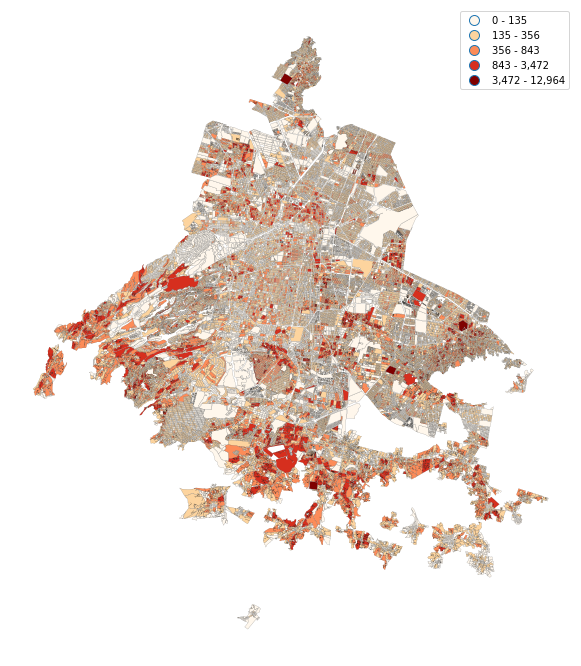

In [24]:
static_map(census,'POBTOT','blocks')

- Pop(CDMX) = 8.8M
    
- Area(CDMX) = 1,485 $km^2$
   
- To deliver impactful policy recommendations from Cuebiq data, we need to merge with census/survey data at the block level

    - Understand vulnerability of population subgroups

    - Generalize to the whole population (post-stratification)
        
- Problems:

    - Large heterogeneity within $1km^2$ for a city like Mexico City
    
    - Census is divided in 65,000 blocks, half of which have less than 100 households

- Solution:
    - Agglomerative clustering of census blocks:
        - Choose an acceptable privacy threshold (E.g. pop=100)
        - Iteratively merge each census block that has a population below the threshold with its closest neighbor 
        - Stop when all clusters have a population larger than the threshold
    - Best of both world
        - Accounts for privacy constraints
        - Allows to match Cuebiq data with official statistics

//anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:482: UserWarning: Deprecated (2.1.0): Fisher_Jenks is being renamed to FisherJenks. Fisher_Jenks will be removed on 2020-01-31.
  warn(self.message)


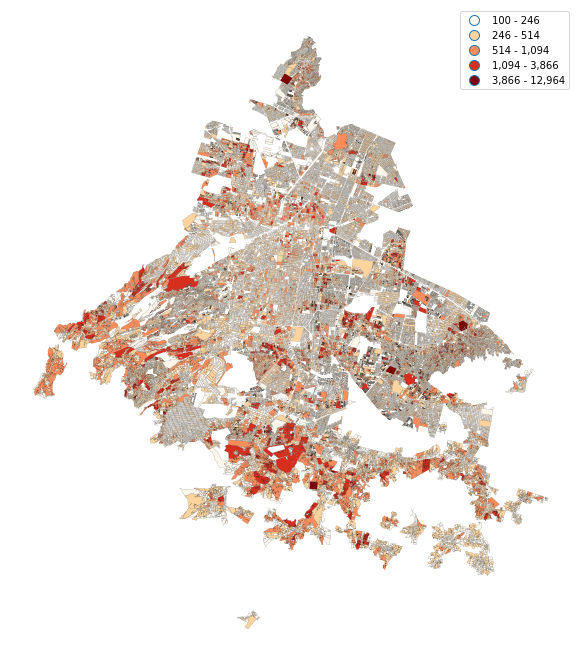

In [25]:
static_map(census_clustered_diff[census_clustered_diff['POBTOT']>0],'POBTOT','clusters')

In [21]:
print('Map Clusters:')
start = timer()

# Data
np.random.seed(0)
id_sample = np.random.choice(census.loc[census['POBTOT']>0,'CLUSTER'].unique(),250)
blocks_to_plot = census[census['CLUSTER'].isin(id_sample)].reset_index(drop=True).reset_index()
print('# Sampled Blocks:',len(blocks_to_plot))

clusters_to_plot = census_clustered[census_clustered['CLUSTER'].isin(id_sample)].reset_index(drop=True).reset_index()

####################################################################################

# Map
m = folium.Map(
location = [19.4, -99.13],
zoom_start = 10, 
tiles = 'cartodbpositron',
)

####################################################################################
m.choropleth(
geo_data=blocks_to_plot.to_json(),
name='Blocks',
data=blocks_to_plot,
columns=['index', 'POBTOT'],
fill_color='PuBu',
key_on='feature.properties.index',
legend_name='Blocks Population',
fill_opacity = 0.5,
line_opacity = 1.,
line_weight=1,
highlight=True,
)

####################################################################################

markers = folium.FeatureGroup(name='Blocks Labels')

for idx, row in blocks_to_plot.iterrows():
    popup = 'Block\'s Population = '+str(row['POBTOT'])
    markers.add_child(folium.CircleMarker([row.geometry.centroid.y, row.geometry.centroid.x], 
                        tooltip=popup,
                        radius=1, 
                        color='black',
                        fill=True,
                        fill_opacity=1,))
    
m.add_child(markers)

####################################################################################

m.choropleth(
geo_data=clusters_to_plot.to_json(),
name='Clusters',
data=clusters_to_plot,
columns=['index', 'POBTOT'],
fill_color='YlOrRd',
key_on='feature.properties.index',
legend_name='Clusters Population',
fill_opacity = 0.5,
line_opacity = 1.,
line_weight=1,
highlight=True,
)

####################################################################################

markers = folium.FeatureGroup(name='Clusters Labels')

for idx, row in clusters_to_plot.iterrows():
    popup = 'Cluster\'s Population = '+str(row['POBTOT'])
    markers.add_child(folium.CircleMarker([row.geometry.centroid.y, row.geometry.centroid.x], 
                        tooltip=popup,
                        radius=1, 
                        color='black',
                        fill=True,
                        fill_opacity=1,))
    

m.add_child(markers)

####################################################################################

# enable layers to be turned in or out
folium.LayerControl().add_to(m)

m.save('../figures/blocks-clusters.html')
    
end = timer()
print('Computing Time:', round(end - start), 'sec')

Map Clusters:
# Sampled Blocks: 433
Computing Time: 2 sec


In [22]:
m

In [23]:
print('Map Parents Children:')
start = timer()

# Data
np.random.seed(0)
id_sample = np.random.choice(parent_and_children['IDX_PARENT'].unique(),50)
# id_sample = [121,125,442]

blocks_to_plot = parent_neighbors_and_children[
parent_neighbors_and_children['IDX_PARENT'].isin(id_sample)].reset_index(drop=True).reset_index()
print('# Sampled Blocks:',len(blocks_to_plot))

clusters_to_plot = clusters_parent_neighbors_and_children[
clusters_parent_neighbors_and_children['IDX_PARENT'].isin(id_sample)].reset_index(drop=True).reset_index()

####################################################################################

# Map
m = folium.Map(
location = [19.4, -99.13],
zoom_start = 10, 
tiles = 'cartodbpositron',
)

####################################################################################
m.choropleth(
geo_data=blocks_to_plot.to_json(),
name='Blocks',
data=blocks_to_plot,
columns=['index', 'POBTOT'],
fill_color='PuBu',
key_on='feature.properties.index',
legend_name='Blocks Population',
fill_opacity = 0.5,
line_opacity = 1,
line_weight = 1,
highlight=True,
)

####################################################################################

markers = folium.FeatureGroup(name='Blocks Labels')

for idx, row in blocks_to_plot.iterrows():
    popup = 'Block Population = '+str(row['POBTOT'])
    markers.add_child(folium.CircleMarker([row.geometry.centroid.y, row.geometry.centroid.x], 
                        tooltip=popup,
                        radius=1, 
                        color='black',
                        fill=True,
                        fill_opacity=1,))
    
m.add_child(markers)

####################################################################################

m.choropleth(
geo_data=clusters_to_plot.to_json(),
name='Clusters',
data=clusters_to_plot,
columns=['index', 'POBTOT'],
fill_color='YlOrRd',
key_on='feature.properties.index',
legend_name='Clusters Population',
fill_opacity = 0.5,
line_opacity = 1.,
line_weight=1,
highlight=True,
)

####################################################################################

markers = folium.FeatureGroup(name='Clusters Labels')

for idx, row in clusters_to_plot.iterrows():
    popup = 'Cluster Population = '+str(row['POBTOT'])
    markers.add_child(folium.CircleMarker([row.geometry.centroid.y, row.geometry.centroid.x], 
                        tooltip=popup,
                        radius=1, 
                        color='black',
                        fill=True,
                        fill_opacity=1,))
    

m.add_child(markers)

####################################################################################

# enable layers to be turned in or out
folium.LayerControl().add_to(m)

m.save('../figures/parents-children.html')
    
end = timer()
print('Computing Time:', round(end - start), 'sec')

Map Parents Children:
# Sampled Blocks: 562
Computing Time: 3 sec


In [24]:
m

In [25]:
print('Map Empty Shapes:')
start = timer()

# Data

blocks_to_plot = census_clustered[census_clustered['POBTOT']==0].reset_index(drop=True).reset_index()
print('# Sampled Blocks:',len(blocks_to_plot))

####################################################################################

# Map
m = folium.Map(
location = [19.4, -99.13],
zoom_start = 10, 
tiles = 'cartodbpositron',
)

####################################################################################
m.choropleth(
geo_data=blocks_to_plot.to_json(),
name='Blocks',
data=blocks_to_plot,
columns=['index', 'POBTOT'],
fill_color='PuBu',
key_on='feature.properties.index',
legend_name='Blocks Population',
fill_opacity = 0.5,
line_opacity = 1.,
line_weight=1,
highlight=True,
)

####################################################################################

# enable layers to be turned in or out
folium.LayerControl().add_to(m)

m.save('../figures/empty-blocks.html')
    
end = timer()
print('Computing Time:', round(end - start), 'sec')

Map Empty Shapes:
# Sampled Blocks: 2653
Computing Time: 3 sec


In [26]:
print('Examples Of Clusters')

####################################################################################
# Data

# cluster_id = 2706
# cluster_id = 2979
# cluster_id = 3259

# blocks_to_plot = census[census['CVEGEO'].isin(CLUSTER2CVEGEOLIST[cluster_id])].copy()
# clusters_to_plot = census_clustered[census_clustered['CLUSTER']==cluster_id].copy()

# cluster_id = 121
cluster_id = 125
# cluster_id = 442
blocks_to_plot, clusters_to_plot = data_parent_and_children(cluster_id, clusters)

####################################################################################
# Map

m = folium.Map(
location = [clusters_to_plot.geometry.centroid.values[0].y, 
            clusters_to_plot.geometry.centroid.values[0].x],
zoom_start = 15, 
tiles = 'cartodbpositron',
)

####################################################################################
m.choropleth(
geo_data=blocks_to_plot.to_json(),
name='Blocks',
data=blocks_to_plot,
columns=['CVEGEO', 'POBTOT'],
fill_color='PuBu',
key_on='feature.properties.CVEGEO',
legend_name='Blocks Population',
fill_opacity = 0.5,
line_opacity = 1.,
line_weight=1,
highlight=True,
)

####################################################################################

markers = folium.FeatureGroup(name='Blocks Labels')

for idx, row in blocks_to_plot.iterrows():
    popup = 'Block\'s Population = '+str(row['POBTOT'])
    markers.add_child(folium.CircleMarker([row.geometry.centroid.y, row.geometry.centroid.x], 
                        tooltip=popup,
                        radius=1, 
                        color='black',
                        fill=True,
                        fill_opacity=1,))
    
m.add_child(markers)

####################################################################################

m.choropleth(
geo_data=clusters_to_plot.to_json(),
name='Clusters',
data=clusters_to_plot,
columns=['CLUSTER', 'POBTOT'],
fill_color='YlOrRd',
key_on='feature.properties.CLUSTER',
legend_name='Clusters Population',
fill_opacity = 0.5,
line_opacity = 1.,
line_weight=1,
highlight=True,
)

####################################################################################

markers = folium.FeatureGroup(name='Clusters Labels')

for idx, row in clusters_to_plot.iterrows():
    popup = 'Cluster\'s Population = '+str(row['POBTOT'])
    markers.add_child(folium.CircleMarker([row.geometry.centroid.y, row.geometry.centroid.x], 
                        tooltip=popup,
                        radius=1, 
                        color='black',
                        fill=True,
                        fill_opacity=1,))
    

m.add_child(markers)

####################################################################################


# enable layers to be turned in or out
folium.LayerControl().add_to(m)

m

Examples Of Clusters


In [37]:
def pdf_pops():
    
    name = 'Population'

    with sns.axes_style("white"):
        sns.set_style("ticks")

        fig,ax = plt.subplots(figsize=(10,6))

        data = census['POBTOT']
        y,edges = np.histogram(data, np.histogram_bin_edges(data, bins=101), density=True)
        centers = 0.5*(edges[1:]+ edges[:-1])
        ax.plot(centers,y,'-*',color=sns.color_palette("coolwarm",5)[0],linewidth=.5,markersize=5,label='Blocks')

        data = census_clustered[census_clustered['POBTOT']!=0]['POBTOT'].copy()
        y,edges = np.histogram(data, np.histogram_bin_edges(data, bins=101), density=True)
        centers = 0.5*(edges[1:]+ edges[:-1])
        ax.plot(centers,y,'-o',color=sns.color_palette("coolwarm",5)[-1],linewidth=.5,markersize=3,label='Clusters')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.tick_params(which='both',direction='in',pad=3)
        ax.locator_params(axis='both',numticks=6)
        ax.set_xlabel(name)
        ax.set_ylabel('P( '+name.split(' ')[0]+' )')
        ax.legend(loc='best')
        ax.axvspan(50, 100, alpha=0.25, color='grey')
        ax.set_xlim([50,20000])
        ax.set_ylim([0.0000001,0.1])
    plt.savefig('../figures/pops.pdf',bbox_inches='tight')

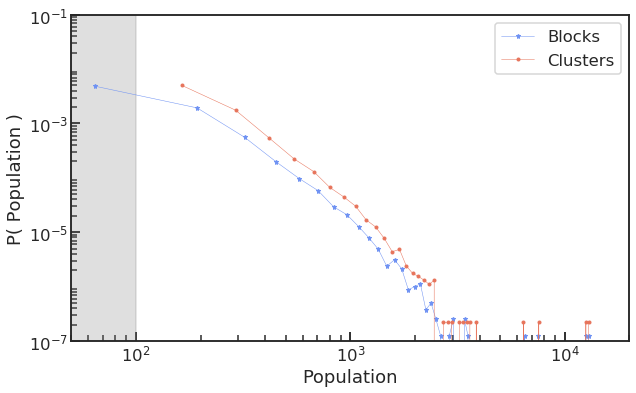

In [38]:
pdf_pops()

In [27]:
def pdf_areas():
    
    name = 'Area (in Km$^2$)'

    with sns.axes_style("white"):
        sns.set_style("ticks")

        fig,ax = plt.subplots(figsize=(10,6))

        census_proj = census.to_crs({'init': 'epsg:3395'})
        data = census_proj['geometry'].area/10**6
        y,edges = np.histogram(data, np.histogram_bin_edges(data, bins=101), density=True)
        centers = 0.5*(edges[1:]+ edges[:-1])
        ax.plot(centers,y,'-*',color=sns.color_palette("coolwarm",5)[0],linewidth=.5,markersize=5,label='Blocks')

        census_clustered_proj = census_clustered.to_crs({'init': 'epsg:3395'})
        data = census_clustered_proj['geometry'].area/10**6
        y,edges = np.histogram(data, np.histogram_bin_edges(data, bins=101), density=True)
        centers = 0.5*(edges[1:]+ edges[:-1])
        ax.plot(centers,y,'-o',color=sns.color_palette("coolwarm",5)[-1],linewidth=.5,markersize=3,label='Clusters')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.tick_params(which='both',direction='in',pad=3)
        ax.locator_params(axis='both',numticks=6)
        ax.set_xlabel(name)
        ax.set_ylabel('P( '+name.split(' ')[0]+' )')
        ax.legend(loc='best')
        ax.axvspan(1, 10, alpha=0.25, color='grey')
        ax.set_xlim([0.01,10])
        ax.set_ylim([0.0001,20])
        
    plt.savefig('../figures/areas.pdf',bbox_inches='tight')

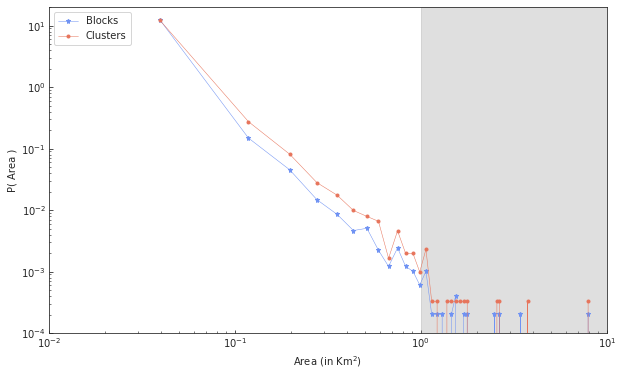

In [28]:
pdf_areas()

- Only 19 blocks have area above 1Km$^2$, and their population is less 0.0004 of the total population.

- Area(CDMX)=1,485KM$^2$

- Using Privacy-preserving Census would be ~25 Times More Granular

In [31]:
def pops_and_areas():
    
    with sns.axes_style("white"):
        sns.set_style("ticks")

        fig,ax = plt.subplots(figsize=(15,10))

        census_proj = census.to_crs({'init': 'epsg:3395'})
        census_proj.groupby(pd.qcut(census_proj['POBTOT'],10,labels=range(1,11)))['geometry'].apply(
        lambda x:x.area.mean()/10**6).reset_index().plot(
        y='geometry',
        x='POBTOT',
        ax=ax,
        marker='.',
        linewidth=.5,
        markersize=8,
        legend=False)
        ax.tick_params(which='both',direction='in',pad=3)
        ax.locator_params(axis='y',nbins=6)
        ax.set_xlabel('Avg. Pop. (in Decile)')
        ax.set_ylabel('Avg. Area (in km$^2$)')
    #     ax.set_xlim([0,11])
    plt.savefig('../figures/pops-and-areas.pdf',bbox_inches='tight')

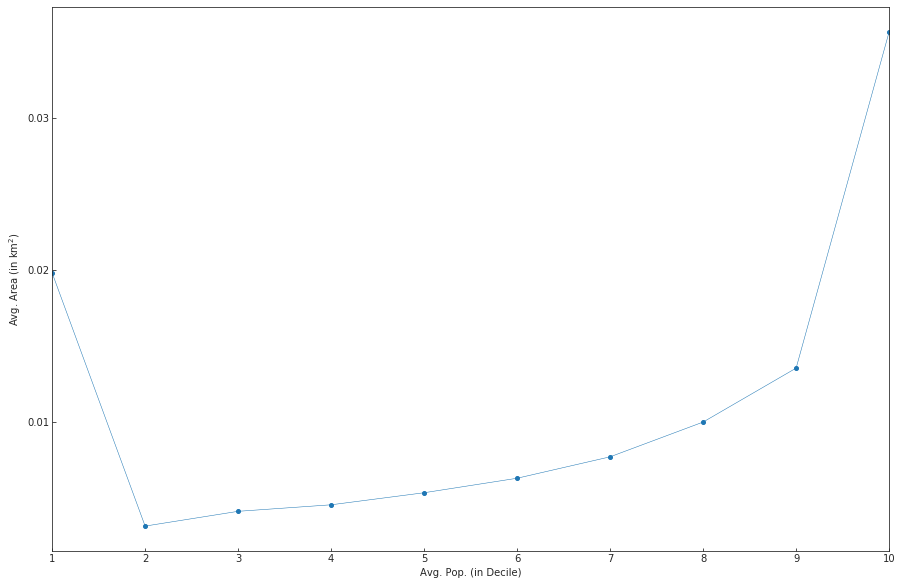

In [32]:
pops_and_areas()

# POIS Twitter

In [33]:
print('Import POIS (Twitter Decahose)')

pois = pd.read_pickle('../data/pois/pois-twitter-cdmx-geocoded.pkl')

top_pois = [
'restaurant',
'bank',
'hospital',
'university',
'bar',
'lodging',
'cafe',
'school',
'shopping_mall',
'museum',
'movie_theater',
'department_store',
'gym',
'store',
]+['']

colors = sns.color_palette("Set3", len(top_pois)+1)

amenity2color = dict(zip(top_pois,colors.as_hex()))

pois['color'] = pois['type'].apply(lambda x:amenity2color[x] if x in amenity2color else amenity2color[''])

pois.drop(['id','candidates','northeast', 'southwest', 'types',],1,inplace=True)

pois.head()

Import POIS (Twitter Decahose)


full_name  n_obs  longitude   latitude  \
0                 222, Cuauhtémoc   1355 -99.161676  19.428425   
1  Chilis Reforma 222, Cuauhtémoc    620 -99.161886  19.429077   
2            Cinemark, Cuauhtémoc    472 -99.161596  19.428811   
3          Pf Chang´s, Cuauhtémoc    189 -99.162322  19.428969   
4            Sanborns, Cuauhtémoc     68 -99.161620  19.428821   

               type            CVEGEO    color  
0     shopping_mall  0901500010803008  #d9d9d9  
1        restaurant  0901500010803008  #8dd3c7  
2     movie_theater  0901500010803008  #ccebc5  
3        restaurant  0901500010803008  #8dd3c7  
4  home_goods_store  0901500010803008  #bebada

In [34]:
def barplot_pois():

    with sns.axes_style("white"):
        sns.set_style("ticks")
        sns.set_context("talk")

        fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))

        to_plot = pois['type'].value_counts().reindex(top_pois[:-1])
        to_plot.index = to_plot.index.map(lambda x:x.title().replace('_',' '))

        to_plot.plot(
        ax=ax,
        kind='bar',
        color=sns.color_palette("Set2",10))

        ax.tick_params(which='both',direction='in',pad=3)
        ax.locator_params(axis='y',nbins=6)
        ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')

    plt.savefig('../figures/pois.pdf',bbox_inches='tight')

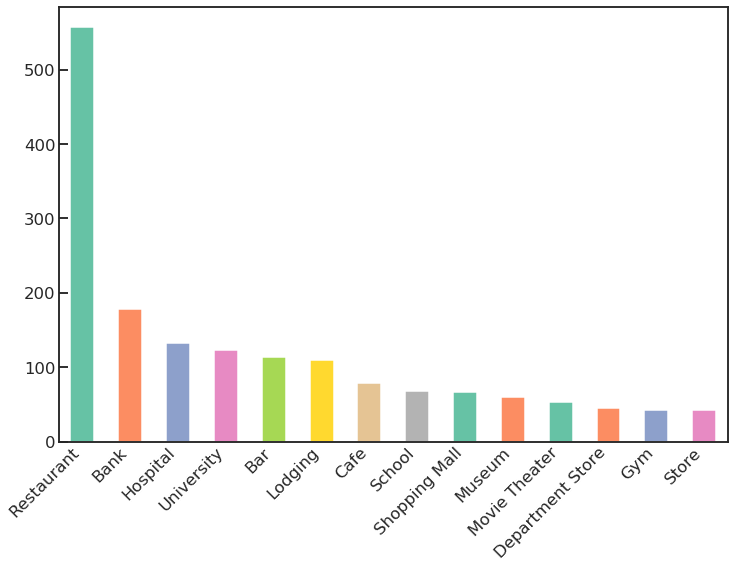

In [35]:
barplot_pois()

In [36]:
print('Map POIS:')
start = timer()

m = folium.Map(
location = [19.4, -99.13],
zoom_start = 10, 
tiles='cartodbpositron',
)

markers = folium.FeatureGroup(name='Points of Interest')

for i, (poi_name, poi_type, color, lat, lon, n_obs) in enumerate(zip(
pois['full_name'],
pois['type'],
pois['color'],
pois['latitude'],
pois['longitude'],
pois['n_obs'])):
    
    if poi_type in top_pois:
        poi_label = poi_type.replace('_',' ').title()
    else:
        poi_label = 'other'
        
    markers.add_child(folium.CircleMarker(
    [lat, lon],
    radius=0.25*np.sqrt(n_obs),
    tooltip = poi_name.title() + ' ('+poi_label+')',
    color=color,
    fill=True,
    weight=0,
    fill_opacity=1,
    ))
    
#     if i > 1000:
#         break
    
m.add_child(markers)

# enable layers to be turned in or out
folium.LayerControl().add_to(m)
   
m.save('../figures/pois.html')
 
end = timer()
print('Computing Time:', round(end - start), 'sec')

Map POIS:
Computing Time: 6 sec
